# Notebook de Estudo do Seq2Seq com Atenção

Rede com dados fakes para fins de debug

In [1]:
!nvidia-smi

Mon Dec 21 20:44:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   36C    P0    35W / 250W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import sys
sys.path.append('..')

In [3]:
from code_utils.metrics import decode_text, generate_sequences, report_linguistic_metrics
from code_utils.models.bilstm.training import define_tokenization_layers, define_full_model
from code_utils.models.bilstm.inference import encoder_inference_model, decoder_inference_model
from code_utils.preprocessing.data_preprocessing import process_data

[nltk_data] Downloading package wordnet to
[nltk_data]     /var/fasttmp/abarbosa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (AdditiveAttention, Attention,
                                     Bidirectional, Dense, Embedding, Input, LSTM)
from tensorflow.keras.utils import plot_model

import pandas as pd

In [5]:
DATA_PATH = "../data/b2w-10k.csv"
SEP=','
REVIEW_TITLE = "review_title"
REVIEW_TEXT = "review_text"
tf.random.set_seed(42)
np.random.seed(42)
START_TOKEN='xxstart'
END_TOKEN='xxend'

In [6]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]
# prepare data for the LSTM
def get_dataset(n_in, n_out, cardinality, n_samples):
    X1, X2, y = list(), list(), list()
    for _ in range(n_samples):
        # generate source sequence
        source = generate_sequence(n_in, cardinality)
        # define padded target sequence
        target = source[:n_out]
        target.reverse()
        # create padded input target sequence
        target_in = [START_TOKEN] + target+[END_TOKEN]
        target = target+[END_TOKEN]
        # store
        X1.append(' '.join(np.array(source).astype('str')))
        X2.append(' '.join(np.array(target_in).astype('str')))
        y.append(' '.join(np.array(target).astype('str')))
    return np.reshape(np.array(X1), (-1,1)),np.reshape(np.array(X2), (-1,1)),np.reshape(np.array(y), (-1,1))
# configure problem
n_features = 50 + 1
n_steps_in = 20
n_steps_out = 5

encoder_train, decoder_train, decoder_label_train = get_dataset(n_steps_in, n_steps_out, n_features, 100000)
encoder_test, decoder_test, decoder_label_test = get_dataset(n_steps_in, n_steps_out, n_features, 10000)

In [7]:
ENCODER_SEQ_LENGTH = 20
DECODER_SEQ_LENGTH = 5

In [8]:
(
    tokenizer_layer_encoder,
    tokenizer_layer_decoder,
    tokenizer_layer_decoder_inference,
) = define_tokenization_layers(
    encoder_train, decoder_train, ENCODER_SEQ_LENGTH, DECODER_SEQ_LENGTH
)

In [9]:
VOCAB_SIZE_encoder = len(tokenizer_layer_encoder.get_vocabulary()) + 2
VOCAB_SIZE_decoder = len(tokenizer_layer_decoder.get_vocabulary()) + 2
BATCH_SIZE = 256
EPOCHS=4
EMBED_DIM = 64  # tamanho do Embedding de cada token
LEARNING_RATE=0.001

In [10]:
# Encoder definition
input_text_encoder = Input(shape=(1,), dtype=tf.string, name="input_text")
emb_enc_layer = Embedding(VOCAB_SIZE_encoder, EMBED_DIM, name="encoder_embedding")
encoder_lstm = Bidirectional(
    LSTM(EMBED_DIM, return_sequences=True, return_state=True, name="encoder_rnn")
)

In [11]:
#Decoder definition 
input_text_decoder = Input(shape=(None,),dtype=tf.string, name="decoder_input")
emb_dec_layer = Embedding(VOCAB_SIZE_decoder, EMBED_DIM,name="decoder_embedding")
decoder_lstm = LSTM(EMBED_DIM*2, return_sequences=True, return_state=True, name="decoder_rnn")
attention_layer = Attention(name="attention", causal=True)
decoder_dense =  Dense(VOCAB_SIZE_decoder, activation='softmax', name="dense_layer")

In [12]:
## Preprocessing step
tokenized_input = tokenizer_layer_encoder(input_text_encoder)  # Tokenizer
tokenized_decoder = tokenizer_layer_decoder(input_text_decoder)
#embedding layer
enc_emb =  emb_enc_layer(tokenized_input)
dec_emb = emb_dec_layer(tokenized_decoder)

In [13]:
model =  define_full_model(input_text_encoder,enc_emb, encoder_lstm,
                       input_text_decoder, dec_emb, decoder_lstm,
                       attention_layer, decoder_dense
                      )

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder_vectorizer (TextVectori (None, 20)           0           input_text[0][0]                 
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 20, 64)       3328        encoder_vectorizer[0][0]         
______________________________________________________________________________________________

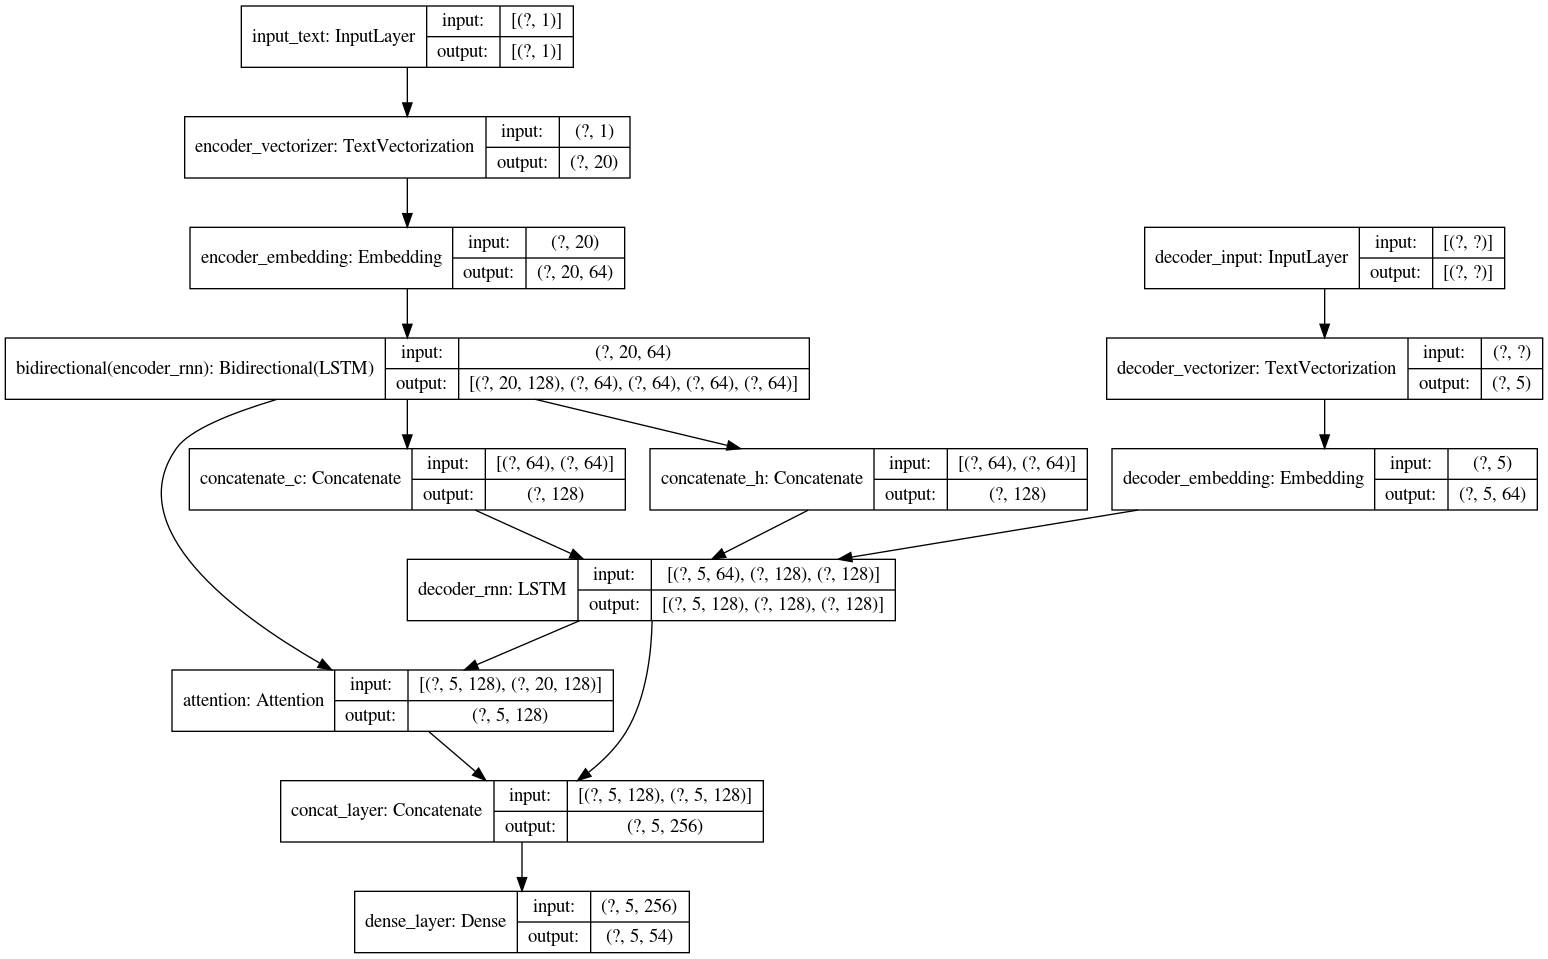

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [16]:
opt = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(
    optimizer=opt,
    loss={"dense_layer": "sparse_categorical_crossentropy"},
    metrics={"dense_layer": "accuracy"},
)

In [17]:
print(f"Forma do Dataset de Treinamento: {encoder_train.shape}")

Forma do Dataset de Treinamento: (100000, 1)


In [18]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]

history = model.fit(
    [encoder_train, decoder_train],
    tokenizer_layer_decoder(decoder_label_train),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=my_callbacks,
    validation_split=0.1
)

Epoch 1/4
352/352 [==============================] - 7s 20ms/step - loss: 2.5434 - accuracy: 0.3009 - val_loss: 1.3867 - val_accuracy: 0.5782
Epoch 2/4
352/352 [==============================] - 6s 18ms/step - loss: 0.8659 - accuracy: 0.7395 - val_loss: 0.5254 - val_accuracy: 0.8412
Epoch 3/4
352/352 [==============================] - 6s 18ms/step - loss: 0.3155 - accuracy: 0.9105 - val_loss: 0.1712 - val_accuracy: 0.9589
Epoch 4/4
352/352 [==============================] - 6s 18ms/step - loss: 0.1126 - accuracy: 0.9760 - val_loss: 0.0770 - val_accuracy: 0.9853


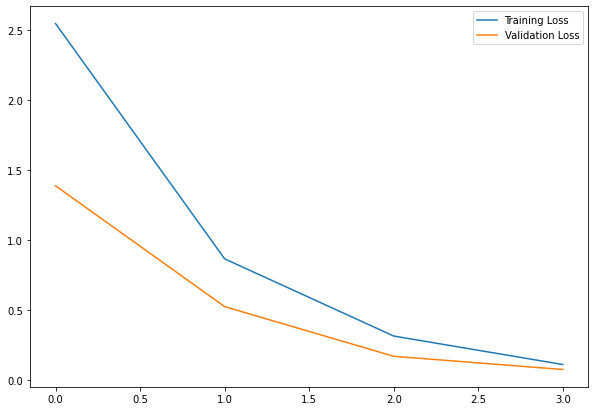

In [19]:
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

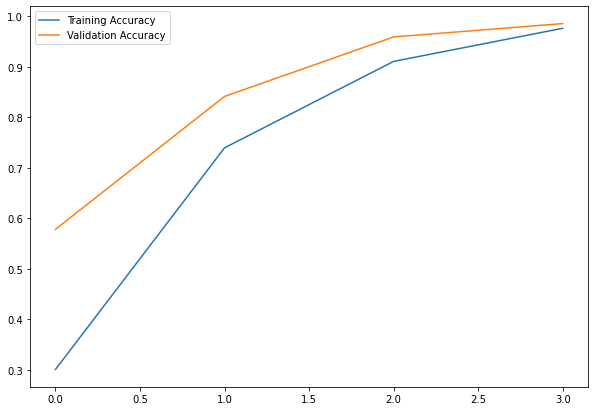

In [20]:
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['accuracy'],label='Training Accuracy')
b, = plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend(handles=[a,b])
plt.show()

In [21]:
test_loss, test_acc = model.evaluate([encoder_test, decoder_test],
                                          tokenizer_layer_decoder(decoder_label_test),
                                          batch_size=128)

79/79 [==============================] - 1s 9ms/step - loss: 0.0785 - accuracy: 0.9845


In [22]:
tokenized_decoder_inference = tokenizer_layer_decoder_inference(input_text_decoder)
dec_emb_embedding_inference = emb_dec_layer(tokenized_decoder_inference)

In [23]:
encoder_inference = encoder_inference_model(input_text_encoder, encoder_lstm, enc_emb)

In [24]:
decoder_inference = decoder_inference_model(
    decoder_embedding=dec_emb_embedding_inference,
    target_text=input_text_decoder,
    latent_dim=EMBED_DIM,
    encoder_sequence_length=ENCODER_SEQ_LENGTH,
    decoder_lstm=decoder_lstm,
    attention_layer=attention_layer,
    decoder_dense=decoder_dense,
)

In [25]:
sentences = generate_sequences(
    encoder_test,
    decoder_label_test,
    100,
    encoder_inference,
    decoder_inference,
    DECODER_SEQ_LENGTH,
    tokenizer_layer_decoder_inference,
)

Gerando Predições: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


In [26]:
sentences.head()

,target_processed,predicted
7270,[16 25 35 40 2 xxend],16 25 35 40 2
860,[15 21 32 46 16 xxend],15 21 32 46 16
5390,[33 40 16 20 39 xxend],33 40 16 20 39
5191,[20 23 43 34 7 xxend],20 23 43 34 7
5734,[34 34 34 19 32 xxend],34 34 34 19 32


In [27]:
bleu_metric, nist_metric, meteor_metric = report_linguistic_metrics(sentences)

In [28]:
pd.DataFrame([test_acc, bleu_metric, nist_metric, meteor_metric]).T.rename(columns={0:'accuracy',
                                                                                    1:'bleu score',
                                                                                    2:'nist score',
                                                                                    3:'meteor score'})

,accuracy,bleu score,nist score,meteor score
0,0.98454,0.611876,5.679358,0.811206
